# Estimating Rebalancing Needs
The most interesting problem with bike share programs is that of rebalancing the system when asymmetric use occurs. Usually, this type of asymmetry is the result of some external factor like elevation or commute. In the analysis below I will attempt to develop a way to spot asymmetrical ridership in the bay area bike share program. I will not be attempting the actual rebalancing optimization, but rather suggesting the number of bikes that need to be added to a given station and where they can come from (How they are added is a whole different can of worms).

All of my analysis and reccomendations will be focused in San Francisco. The other cities in the south bay have very low ridership numbers and are subsequently not that interesting.

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt
import numpy as np
filename1 = 'LDA_DATA.csv'
filename2 = 'station_locations.csv'
df0 = pd.read_csv('./csv/'+filename1, index_col = 0)
station_locations = pd.read_csv('./csv/'+filename2, index_col=0) #found the lat., long. of stations online, nice! 

I have a feeling that use of the system will be heavily tied to time of day and day of week. I will start by exploring this hunch.

In [3]:
df0['Start Date'] = pd.to_datetime(df0['Start Date'], errors='coerce') #convert strings to datetime
df0['End Date'] = pd.to_datetime(df0['End Date'], errors='coerce')

In [21]:
df0['DoWS'] = df0['Start Date'].dt.weekday #get days of week
df0['ToDS'] = np.where(df0['Start Date'].dt.hour < 12, 'AM', 'PM') #get days of week
df0['ToDE'] = np.where(df0['End Date'].dt.hour < 12, 'AM', 'PM') #get days of week
df0['DoWE'] = df0['End Date'].dt.weekday

### Day of Week/Time of Day Ridership

In [24]:
df0[df0['Start Date'].dt.date < df0['End Date'].dt.date].count() ## check how many multiday rides exist //586 
#--> majority of rides start and end on the same day, safe to approximate ridership load w/ start or end date on day basis

Duration           586
Start Date         586
Start Station      586
Start Terminal     586
End Date           586
End Station        586
End Terminal       586
Bike #             586
Subscriber Type    586
Zip Code           584
DoWS               586
ToDS               586
ToDE               586
DoWE               586
dtype: int64

### Double Counting
Need to understand how many rides span days of the week in order to group by day of week on start date and end date. I will end up double counting these rides when grouping on day, so it's important to understand my exposure. I feel like 586 is acceptable relative to the overall sample size.




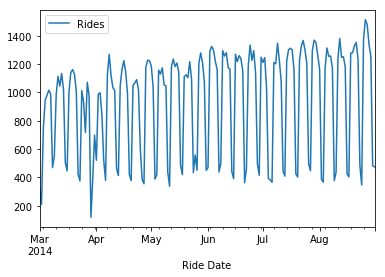

In [5]:
daydf = df0[['Start Date', 'DoWS']]
daydf.index = daydf['Start Date']
daydf = daydf.drop('DoWS', axis=1)
daydf = daydf.resample('D').count()
daydf.index.name = 'Ride Date'
daydf.columns = ['Rides']
plt.figure()
daydf.plot()

Looks like ridership drops on the weekends. Should confirm with a look at aggregate day of week totals. This leads me to think that bikes are being used for work commute most of the time.

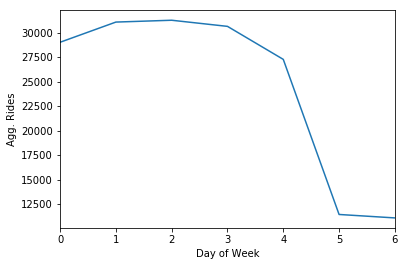

In [6]:
dow = df0['Start Date'].groupby(df0['DoWS']).count()
dow.index.name = 'Day of Week'
plt.figure()
plt.ylabel('Agg. Rides')
dow.plot()


Yes, ridership is definitely lower on the weekeds! To confirm, should look at time of day ridership on the weekdays.

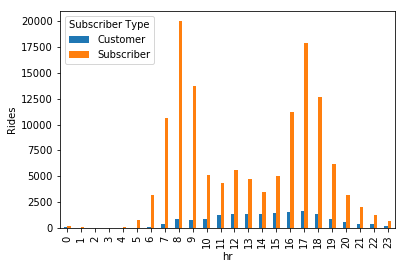

In [7]:
dow_only = df0[df0['DoWS'] < 5] #weekdays only
tod_tot = pd.crosstab(dow_only['Start Date'].dt.hour, dow_only['Subscriber Type']) #
tod_tot
tod_tot.index.name = 'hr'
plt.figure()
tod_tot.plot(kind='bar')
plt.ylabel('Rides')

Weekday ridership is clearly bimodal. Highest ridership between 7-9am and 4-6pm, supports the commute hypothesis. Also subscribers tend to be to be commuters. Will focus on commute stations.

In [8]:
station_pop = dow_only.groupby(['Start Station', 'End Station'], sort=True)
stations = station_pop.agg({
    'Start Station': 'count',
    'Duration': 'mean'})
stations.columns = ['Average Duration', 'Rides Started']
stations['Rides Started'].sort_values(ascending=False).head(10)

Start Station                             End Station                                  
Townsend at 7th                           San Francisco Caltrain (Townsend at 4th)         1414
San Francisco Caltrain 2 (330 Townsend)   Townsend at 7th                                  1274
Harry Bridges Plaza (Ferry Building)      Embarcadero at Sansome                           1213
Embarcadero at Sansome                    Steuart at Market                                1046
2nd at South Park                         Market at Sansome                                1021
2nd at Townsend                           Harry Bridges Plaza (Ferry Building)             1015
Market at 10th                            San Francisco Caltrain (Townsend at 4th)          960
Steuart at Market                         San Francisco Caltrain (Townsend at 4th)          943
San Francisco Caltrain (Townsend at 4th)  Temporary Transbay Terminal (Howard at Beale)     926
                                          Market

Above are the 10 most popular routes in the system. We would expect that the popularity of these stations w.r.t the time of day will follow that of the overall population.

# Calculating Net Station Flow
Net station flow is defined as Rides_Ending - Rides_Starting in a time period. If net station flow is negative, more bikes are being ridden from the station than to it.
### DOW and TOD Grouping

In [22]:
####Rides Started ToD####
dftemps = df0.groupby(["Start Station", 'DoWS', df0['Start Date'].dt.date, 'ToDS']).count()['Duration'] #rides started by station per day
####Rides Ended ToD####
dftempe =df0.groupby(["End Station", 'DoWE', df0['End Date'].dt.date, 'ToDE']).count()['Duration']#rides ended by station per day


Above groups and counts the initial dataframe on station, date and time of day for both rides started and ended. This counts all rides started at a given station for the day of week, date and time of day (see example structure below). The goal will be to subtract rides starting at a give station from the rides ending to get a net bike flow for a given time period. This net flow will be used to approximate the change in inventory at the station.

In [23]:
dftemps.head()

Start Station  DoWS  Start Date  ToDS
2nd at Folsom  0     2014-03-03  AM      10
                                 PM      19
                     2014-03-10  AM       6
                                 PM      26
                     2014-03-17  AM       8
Name: Duration, dtype: int64

In [12]:
dftempe.index.levels[1].name='DoWS'
dftempe.index.levels[0].name='Start Station'
dftempe.index.levels[2].name = 'Start Date'
dftempe.index.levels[3].name = 'ToDS'
#name indexes the same for both dataframes so that they may be subtracted

Because there are only about 25 weeks in the dataset, we end up with only 25 data points for every mean net flow statistic. This is a pretty small sample, so we can't be certain that the means are representative of the population, i.e. the actual mean net flow for a station. A way around this is to resample the data randomly and compute a confidence interval from the resampled data. Below we calculate the 90% confidence interval for the sample mean net flow with a resample size of 100.

In [18]:
import scipy as sp
import scipy.stats as stats
import math

grouped_sample = dftempe.sub(dftemps).fillna(0).groupby(['Start Station', 'DoWS', 'ToDS'])#subtract dataframes, group
sample = grouped_sample.agg([np.mean]) #calculate sample means
sample['Conf_L'] = 'Nan'
sample['Conf_H'] = 'Nan'

n=100 #bootstrap sample size
strap = {}
for i in range(n):
    experiment = dftempe.sub(dftemps).fillna(0).sample(n=11649, replace=True) #sample w/ same dimensions + replacement
    grouped = experiment.groupby(['Start Station', 'DoWS', 'ToDS'])
    strap[i] = grouped.agg([np.mean]) #calc means of bootstrap samples
    
for index in sample.index:
    arr = []
    for i in range(n):
        try:
            arr.append(strap[i].loc[index].values[0]-sample.loc[index].values[0]) #find deviations from sample mean, handle missing station data 
        except:
            arr.append(False)
    arr.sort()
    sample.set_value(index,'Conf_L', arr[5])
    sample.set_value(index,'Conf_H', arr[95])#assign 90% confidence interval to sample mean dataframe

### DOW Only Grouping
Just repeating the above steps minus the time of day.

In [26]:
####Rides Started DAY####
dftemps = df0.groupby(["Start Station", 'DoWS',df0['Start Date'].dt.date]).count()['Duration'] #rides started by station per day

In [27]:
####Rides Ended DAY####
dftempe =df0.groupby(["End Station", 'DoWE', df0['End Date'].dt.date]).count()['Duration'] #rides ended by station per day

In [28]:
dftempe.index.levels[1].name='DoWS'
dftempe.index.levels[0].name='Start Station'
dftempe.index.levels[2].name = 'Start Date'

In [29]:
grouped_sample = dftempe.sub(dftemps).fillna(0).groupby(['Start Station', 'DoWS'])
sample = grouped_sample.agg([np.mean])
sample['Conf_L'] = 'Nan'
sample['Conf_H'] = 'Nan'

n=100 #samples
strap = {}
for i in range(n):
    experiment = dftempe.sub(dftemps).fillna(0).sample(n=11649, replace=True)
    grouped = experiment.groupby(['Start Station', 'DoWS'])
    strap[i] = grouped.agg([np.mean])
    
for index in sample.index:
    arr = []
    for i in range(n):
        try:
            arr.append(strap[i].loc[index].values[0]-sample.loc[index].values[0])
        except:
            arr.append(False)
    arr.sort()
    sample.set_value(index,'Conf_L', arr[5])
    sample.set_value(index,'Conf_H', arr[95])

In [30]:
station_locations.index.name = 'Start Station'
sample=sample.join(station_locations[['landmark', 'dockcount']])

In [31]:
flow = sample
ad = []
for i in flow.index:
    d = dict()
    d['station']=i[0]
    d['dow'] = i[1]
    d['tod'] = i[2]
    d['net_rides_avg'] = flow.get_value(i, 'mean')
    d['net_rides_CIL'] = flow.get_value(i, 'Conf_L')
    d['net_rides_CIH'] = flow.get_value(i, 'Conf_H')
    d['city'] = flow.get_value(i, 'landmark')
    d['capacity'] = flow.get_value(i, 'dockcount')
    ad.append(d)

In [32]:
import json
with open('./demand_dow.json', 'w') as outfile:
    json.dump(ad, outfile)
with open('./demand_tod.json', 'w') as outfile:
    json.dump(ad, outfile)

In [4]:
bikes = np.sort(df0['Bike #'].unique())
rebcount_all = {}
for bike in bikes: 
    rebcheck = df0.loc[df0[df0['Bike #'] == bike]['Start Date'].sort_values().index]
    to_ = rebcheck[rebcheck['Start Terminal'] != rebcheck['End Terminal'].shift(1)][['Start Station', 'Start Date']]
    from_ = rebcheck[rebcheck['End Terminal'] != rebcheck['Start Terminal'].shift(-1)][['End Station', 'End Date']]
    from_.reset_index(inplace=True)
    to_=to_.iloc[1:]
    to_.reset_index(inplace=True)
    reb = from_.join(to_ , how='left', rsuffix='_to', lsuffix='_from')
    rebcount_all[bike] = reb

In [5]:
rebtot = rebcount_all[569]
for bike in bikes:
    if bike != 569:
        rebtot = rebtot.append(rebcount_all[bike], ignore_index=True)

In [6]:
rebtot['DoWS'] = rebtot['Start Date'].dt.weekday #get days of week
rebtot['ToDS'] = np.where(rebtot['Start Date'].dt.hour < 12, 'AM', 'PM') #get days of week
rebtot['ToDE'] = np.where(rebtot['End Date'].dt.hour < 12, 'AM', 'PM') #get days of week
rebtot['DoWE'] = rebtot['End Date'].dt.weekday

In [14]:
rebtot_cnt_to = rebtot.groupby(['Start Station', 'DoWS', rebtot['Start Date'].dt.date]).count()
rebtot_mean_to = rebtot_cnt_to.groupby(['Start Station', 'DoWS']).mean()

In [15]:
rebtot_cnt_from = rebtot.groupby(['End Station', 'DoWS', rebtot['Start Date'].dt.date]).count()
rebtot_mean_from = rebtot_cnt_from.groupby(['End Station', 'DoWS']).mean()

In [18]:
rebtot_mean_to['Trip ID_from']

Start Station                                  DoWS
2nd at Folsom                                  0.0     14.960000
                                               1.0     15.320000
                                               2.0     13.520000
                                               3.0     13.461538
                                               4.0     10.076923
                                               5.0      3.880000
                                               6.0      3.318182
2nd at South Park                              0.0     12.208333
                                               1.0     10.125000
                                               2.0      8.807692
                                               3.0      7.730769
                                               4.0      6.608696
                                               5.0      2.800000
                                               6.0      3.105263
2nd at Townsend                       